In [1]:
require(nnet)
require(car)

Loading required package: nnet

Loading required package: car

Loading required package: carData



In [21]:
summary(dat$los)

length(dat$los)

sum(dat$los > 13 + (13 - 4) * 1.5)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   4.000   8.000   9.854  13.000 116.000 

[1] 1495

[1] 52

In [2]:
dat <- read.csv("admissions.csv")
head(dat)

,provnum,died,white,los,age80,age,admission
,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,30001,0,1,4,0,4,Elective
2,30001,0,1,9,0,4,Elective
3,30001,1,1,3,1,7,Elective
4,30001,0,1,9,0,6,Elective
5,30001,1,1,1,1,7,Elective
6,30001,1,1,4,0,5,Elective


In this practical we are going to investigate how the probability of type of hospital admission changes given some
covariates using the admissions data by

In [3]:
library(ggplot2)
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

Warning message:
“package ‘ggplot2’ was built under R version 4.1.1”


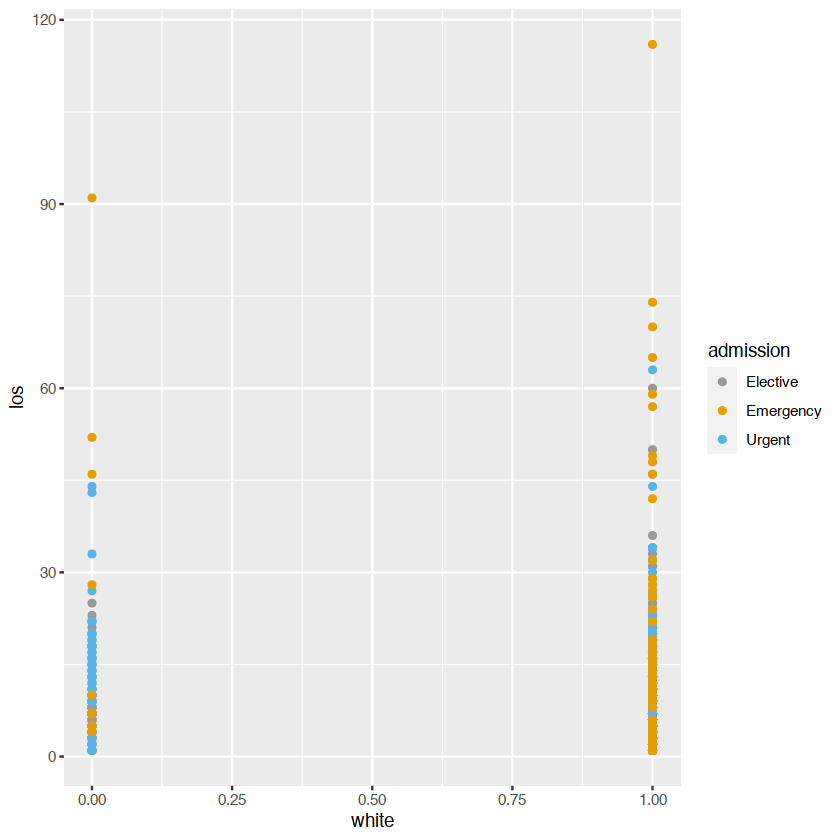

In [4]:
ggplot(dat, aes(white, los, colour=admission)) + geom_point() + scale_colour_manual(values=cbPalette)

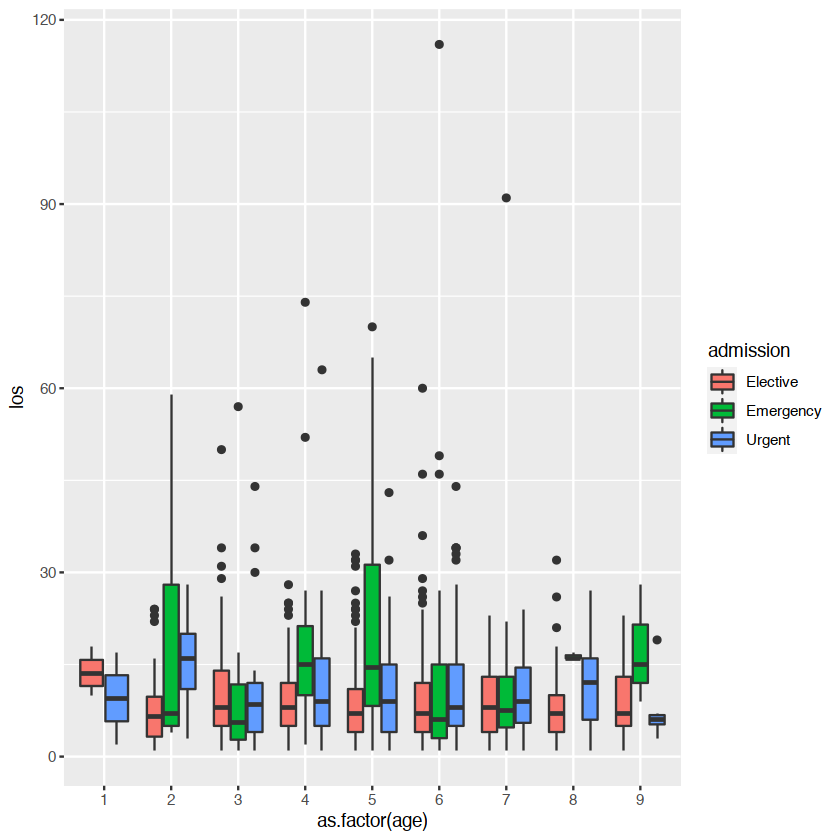

In [5]:
ggplot(dat, aes(as.factor(age), los, fill = admission)) + geom_boxplot()

In [6]:
table(dat$white) # disproportionate number of white people compared to black. Only 10% non-white people


   0    1 
 127 1368 

In [3]:
table(dat$died)


  0   1 
982 513 

In [7]:
prop.table(table(dat$admission)) # dispproportionate number of cases in each category


  Elective  Emergency     Urgent 
0.75852843 0.06421405 0.17725753 

In [8]:
table(dat$admission, dat$white)

           
               0    1
  Elective    80 1054
  Emergency   10   86
  Urgent      37  228

In [9]:
non_white = dat[dat$white == 0,]
prop.table(table(non_white$admission))
white = dat[dat$white == 1, ]
prop.table(table(white$admission))


  Elective  Emergency     Urgent 
0.62992126 0.07874016 0.29133858 


 Elective Emergency    Urgent 
0.7704678 0.0628655 0.1666667 

In [10]:
table(dat$died)


  0   1 
982 513 

In [12]:
levels(as.factor(dat$admission))

[1] "Elective"  "Emergency" "Urgent"

### Model by backwards removal

vif manually on 2 glm models

In [13]:
model<-multinom(admission ~ as.factor(died) + as.factor(white) + los + as.factor(age),dat=dat)
labels = rownames(coefficients(model))
ref = setdiff(model$lab,labels)
print(t(sapply(labels,function(i){
       dat = dat
       dat$Admission = as.numeric(dat$admission == i)
       vif(glm(Admission ~ as.factor(died) + as.factor(white) + los + as.factor(age), data=dat,family="binomial"))
})))

# weights:  39 (24 variable)
initial  value 1642.425372 
iter  10 value 1014.997824
iter  20 value 976.611848
iter  30 value 975.609193
iter  40 value 975.339192
final  value 975.336370 
converged
              [,1]     [,2]     [,3]     [,4] [,5] [,6] [,7] [,8]     [,9]
Emergency 1.049889 1.081559 1.038056 1.118861    1    1    1    8 1.024641
Urgent    1.037302 1.130156 1.017208 1.154036    1    1    1    8 1.018480
             [,10]    [,11]    [,12]
Emergency 1.039980 1.018850 1.007044
Urgent    1.063088 1.008567 1.008994


In [22]:
# Fit model with given parameters
model<-multinom(
    admission ~ 
        as.factor(died) + 
        as.factor(white) + 
        los + 
        as.factor(age) + 
        los * as.factor(white) + 
        los*as.factor(age) + 
        as.factor(age) * as.factor(white),
    dat=dat
)
summary(model)
print(Anova(model)) # anova shows that age is not significant at 5% level,
#no difference between the full model and the restricted model. p-value 0.7
#remove age as it's not significant to predict the admission type
model = update(model, .~.-as.factor(age))
print(Anova(model)) # everything is significant now
AIC(model)

# weights:  90 (58 variable)
initial  value 1642.425372 
iter  10 value 1094.161049
iter  20 value 1061.496898
iter  30 value 979.102041
iter  40 value 955.403472
iter  50 value 953.091168
iter  60 value 953.011049
iter  70 value 953.008167
iter  80 value 953.005511
final  value 953.005402 
converged


Call:
multinom(formula = admission ~ as.factor(died) + as.factor(white) + 
    los + as.factor(age) + los * as.factor(white) + los * as.factor(age) + 
    as.factor(age) * as.factor(white), data = dat)

Coefficients:
          (Intercept) as.factor(died)1 as.factor(white)1        los
Emergency    -9.00072        0.9543930          4.821014 -0.7091200
Urgent        1.29941        0.4579314          2.771157 -0.2604709
          as.factor(age)2 as.factor(age)3 as.factor(age)4 as.factor(age)5
Emergency        4.679303        6.089380        3.756628      -12.041222
Urgent          -4.193259       -2.715076       -2.603898       -4.226981
          as.factor(age)6 as.factor(age)7 as.factor(age)8 as.factor(age)9
Emergency        3.378802        3.696894       -9.855392       -7.434830
Urgent          -3.018790       -2.506131       -3.251804       -2.757997
          as.factor(white)1:los los:as.factor(age)2 los:as.factor(age)3
Emergency           -0.08288102           0.9738457           0

Analysis of Deviance Table (Type II tests)

Response: admission
                                LR Chisq Df Pr(>Chisq)    
as.factor(died)                   22.457  2  1.329e-05 ***
as.factor(white)                  12.094  2   0.002365 ** 
los                               85.463  2  < 2.2e-16 ***
as.factor(age)                    13.109 16   0.664793    
as.factor(white):los               4.023  2   0.133785    
los:as.factor(age)                24.687 16   0.075528 .  
as.factor(white):as.factor(age)   20.559 16   0.196111    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
# weights:  66 (42 variable)
initial  value 1642.425372 
iter  10 value 1099.734689
iter  20 value 1065.234817
iter  30 value 970.072128
iter  40 value 964.027977
iter  50 value 963.309292
iter  60 value 963.299085
final  value 963.295833 
converged
Analysis of Deviance Table (Type II tests)

Response: admission
                                LR Chisq Df Pr(>Chisq)    
as.factor(died)         

[1] 2010.592

### Model using step function
Fit the model without the collinear (race) variable and perform both backward and forward model selection.

In [23]:
step_model = multinom(
    admission ~ 
        as.factor(died) + 
        as.factor(white) + 
        los + as.factor(age) + 
        los * as.factor(white) + 
        los*as.factor(age) + 
        as.factor(age) * as.factor(white),
    dat=dat
)
step_model = step(step_model, direction="both")
summary(step_model) # this is the same model as the one done by just backward, gives the same AIC.

# weights:  90 (58 variable)
initial  value 1642.425372 
iter  10 value 1094.161049
iter  20 value 1061.496898
iter  30 value 979.102041
iter  40 value 955.403472
iter  50 value 953.091168
iter  60 value 953.011049
iter  70 value 953.008167
iter  80 value 953.005511
final  value 953.005402 
converged
Start:  AIC=2022.01
admission ~ as.factor(died) + as.factor(white) + los + as.factor(age) + 
    los * as.factor(white) + los * as.factor(age) + as.factor(age) * 
    as.factor(white)

trying - as.factor(died) 
# weights:  87 (56 variable)
initial  value 1642.425372 
iter  10 value 1089.962331
iter  20 value 1066.436906
iter  30 value 973.491685
iter  40 value 965.618562
iter  50 value 964.246626
iter  60 value 964.238288
iter  70 value 964.236767
iter  80 value 964.234120
final  value 964.234098 
converged
trying - as.factor(white):los 
# weights:  87 (56 variable)
initial  value 1642.425372 
iter  10 value 1188.905739
iter  20 value 1087.622841
iter  30 value 962.446923
iter  40 value 95

Call:
multinom(formula = admission ~ as.factor(died) + as.factor(white) + 
    los, data = dat)

Coefficients:
          (Intercept) as.factor(died)1 as.factor(white)1        los
Emergency   -3.523321        0.8470658        -0.2778606 0.08230527
Urgent      -1.342438        0.4232942        -0.7381674 0.04069428

Std. Errors:
          (Intercept) as.factor(died)1 as.factor(white)1         los
Emergency   0.4092895        0.2259073         0.3808220 0.009941462
Urgent      0.2303212        0.1440877         0.2154271 0.008499039

Residual Deviance: 1964.406 
AIC: 1980.406 

### dredge selection (all models)

In [24]:
require(MuMIn)
options(na.action='na.fail')
dredge_model = multinom(
    admission ~ 
        as.factor(died) + 
        as.factor(white) + 
        los + as.factor(age) + 
        los * as.factor(white) + 
        los*as.factor(age) + 
        as.factor(age) * as.factor(white), dat=dat
)
head(dredge(dredge_model))

Loading required package: MuMIn



# weights:  90 (58 variable)
initial  value 1642.425372 
iter  10 value 1094.161049
iter  20 value 1061.496898
iter  30 value 979.102041
iter  40 value 955.403472
iter  50 value 953.091168
iter  60 value 953.011049
iter  70 value 953.008167
iter  80 value 953.005511
final  value 953.005402 
converged


Fixed term is "(Intercept)"



# weights:  6 (2 variable)
initial  value 1642.425372 
final  value 1035.470638 
converged
# weights:  30 (18 variable)
initial  value 1642.425372 
iter  10 value 1052.226704
iter  20 value 1029.717241
iter  30 value 1029.366142
final  value 1029.306327 
converged
# weights:  9 (4 variable)
initial  value 1642.425372 
iter  10 value 1029.610778
final  value 1029.609794 
converged
# weights:  33 (20 variable)
initial  value 1642.425372 
iter  10 value 1058.433771
iter  20 value 1023.328403
iter  30 value 1023.017550
iter  40 value 1022.882664
final  value 1022.882545 
converged
# weights:  9 (4 variable)
initial  value 1642.425372 
iter  10 value 1029.430254
final  value 1029.320412 
converged
# weights:  33 (20 variable)
initial  value 1642.425372 
iter  10 value 1047.790175
iter  20 value 1022.876507
iter  30 value 1022.409827
iter  40 value 1022.344716
final  value 1022.344532 
converged
# weights:  12 (6 variable)
initial  value 1642.425372 
iter  10 value 1039.617683
iter  20 value

,(Intercept),as.factor(age),as.factor(died),as.factor(white),los,as.factor(age):as.factor(white),as.factor(age):los,as.factor(white):los,df,logLik,AICc,delta,weight
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<mdl.wght>
15,+,NA,+,+,+,NA,NA,NA,8,-982.2028,1980.502,0.000000,7.375011e-01
79,+,NA,+,+,+,NA,NA,+,10,-981.3083,1982.765,2.262305,2.379630e-01
11,+,NA,+,NA,+,NA,NA,NA,6,-987.6467,1987.350,6.847278,2.403783e-02
13,+,NA,NA,+,+,NA,NA,NA,6,-991.9624,1995.981,15.478738,3.210682e-04
77,+,NA,NA,+,+,NA,NA,+,8,-990.9151,1997.927,17.424589,1.213560e-04
16,+,+,+,+,+,NA,NA,NA,24,-975.3364,1999.489,18.986583,5.557488e-05


### Model interpretation

In [17]:
coef(model)

,(Intercept),as.factor(died)1,as.factor(white)1,los
Emergency,-3.523321,0.8470658,-0.2778606,0.08230527
Urgent,-1.342438,0.4232942,-0.7381674,0.04069428


In [18]:
unique(dat$admission)
data.frame(
    Admission=c("Emergency", "Urgent"),
    OddDifference = c(round(exp(-3.523321), 2), round(exp(-1.342438),2))
)

[1] "Elective"  "Urgent"    "Emergency"

Admission,OddDifference
<chr>,<dbl>
Emergency,0.03
Urgent,0.26


Odds of Emergency vs Elective is 0.03. This means that the probability of being admitted as an emergency is equal to 3% of the probability of being admitted electively when the patient is alive and they are not white. 

Odds of Urgent vs Elective is 0.26. This means that the probability that the patient is admitted urgently is equal to the probability of being admitted electively times 0.26 when the patient leaves the hospital alive and they are not white. Or in other words, non-white patients that are still alive when they leave the hospital are 0.26 times less likely to be admitted urgently instead of electively. 

In [19]:
d = round(predict(model,newdata=data.frame(los=c(2,1), white=1, died=0),type="probs"), 2)
d
print(paste("Emergency", round(exp(log(d[1,2]/d[1,1]) - log(d[2,2]/d[2,1])), 2)))
print(paste("Urgent", round(exp(log(d[1,3]/d[1,1]) - log(d[2,3]/d[2,1])), 2)))

,Elective,Emergency,Urgent
1,0.86,0.02,0.12
2,0.87,0.02,0.11


[1] "Emergency 1.01"
[1] "Urgent 1.1"


When the patient is white and they left the hospital alive after day 2 instead of day 1, the odds of being admitted in an emergency rather than elective increase by 1.01 and the odds of being admitted urgently instead of electively increase by 1.1.

In [21]:
d = round(predict(model,newdata=data.frame(
    los=c(5,5), 
    white=as.factor(1),
    died=c(as.factor(1), as.factor(0))),type="probs"), 2)
d
print(paste("Emergency odds", round(exp(log(d[1,2]/d[1,1]) - log(d[2,2]/d[2,1])), 2)))
print(paste("Urgent odds", round(exp(log(d[1,3]/d[1,1]) - log(d[2,3]/d[2,1])), 2)))

,Elective,Emergency,Urgent
1,0.76,0.06,0.18
2,0.84,0.03,0.13


[1] "Emergency odds 2.21"
[1] "Urgent odds 1.53"


When the patient is white and they stayed 5 days in the hospital, but left dead instead of alive, the odds of being admitted in an emergency are 2.2 times higher than the odds of being admitted electively. Additionally, when a white patient stayed for 5 days in the hospital but died instead of leaving alive, the odds of being admitted urgently are 1.53 times higher than the odds of being admitted electively.

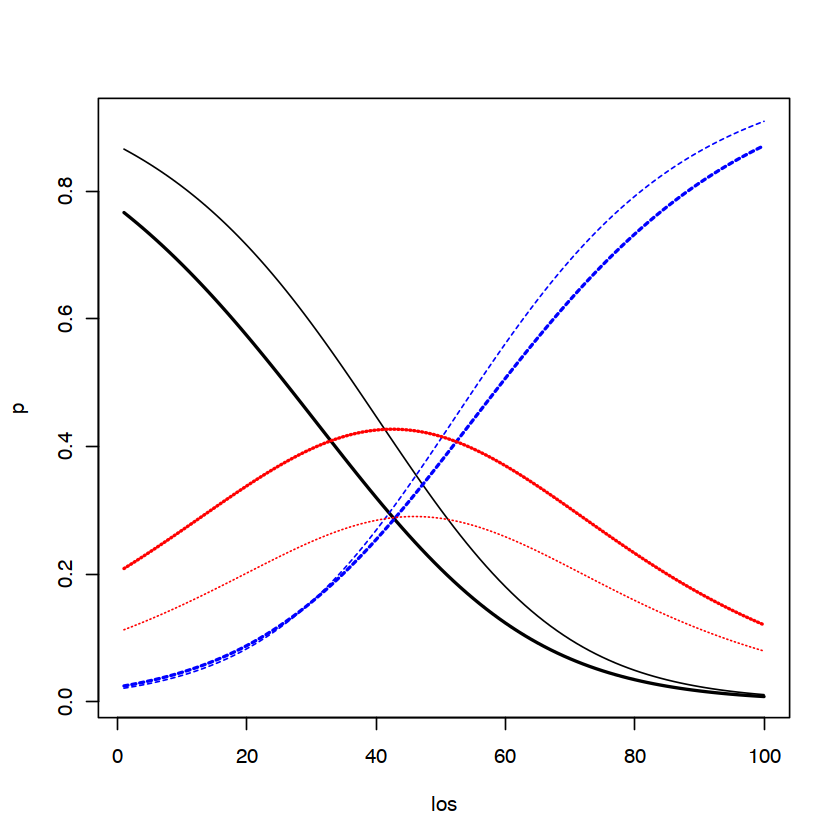

In [23]:
los<-1:100
pred_white<-predict(model,newdata=data.frame(white=as.factor(1), died=as.factor(0),los=los),type="probs")
pred_black<-predict(model,newdata=data.frame(white=as.factor(0), died=as.factor(0),los=los),type="probs")

plot(los,pred_white[,1],type="l",lty=1,ylim=range(pred_white),ylab="p") # elective decrease by length of stay
lines(los,pred_black[,1],lty=1, lwd=2) # emergency
lines(los,pred_white[,2],lty=2, col="blue") # emergency
lines(los,pred_black[,2],lty=2, col="blue", lwd="2") # emergency black
lines(los,pred_white[,3],lty=3, col="red") # urgent
lines(los,pred_black[,3],lty=3, col="red", lwd="2")

In [27]:
round(predict(model, type="probs")[1,]*nrow(dat), 2)
table(dat$admission)

Elective Emergency    Urgent 
  1269.12     39.41    186.47


 Elective Emergency    Urgent 
     1134        96       265 

In [31]:
Anova(model)

,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
as.factor(died),19.51919,2,5.773797e-05
as.factor(white),10.88773,2,4.322742e-03
los,81.63722,2,1.873716e-18


In [33]:
deviance(model)

round(1 - pchisq(deviance(model), nrow(dat) - 6), 2)

[1] 1964.406

[1] 0

### Model assumptions

- Observations come from a multinomial distribution
- Observations are independent, given the covariates
- Log odds of each outcome, relative to a baseline, have a linear relationship with covariates
- Log odds are not affected by other outcomes (assumption of Independence from Irrelevant Alternatives (IIA))


The multinomial distribution assumes that the observations are drawn independently and identically distributed from a multinomial distribution. We can see a clear pattern in the fitted vs residuals (pearson) and there seem to be a high correlation between observations, which gives reasons to believe that the assumptions are violated. This means that the standard error is likely to be overestimated yielding smaller p-values than a model where the autocorrelation would not be present. 

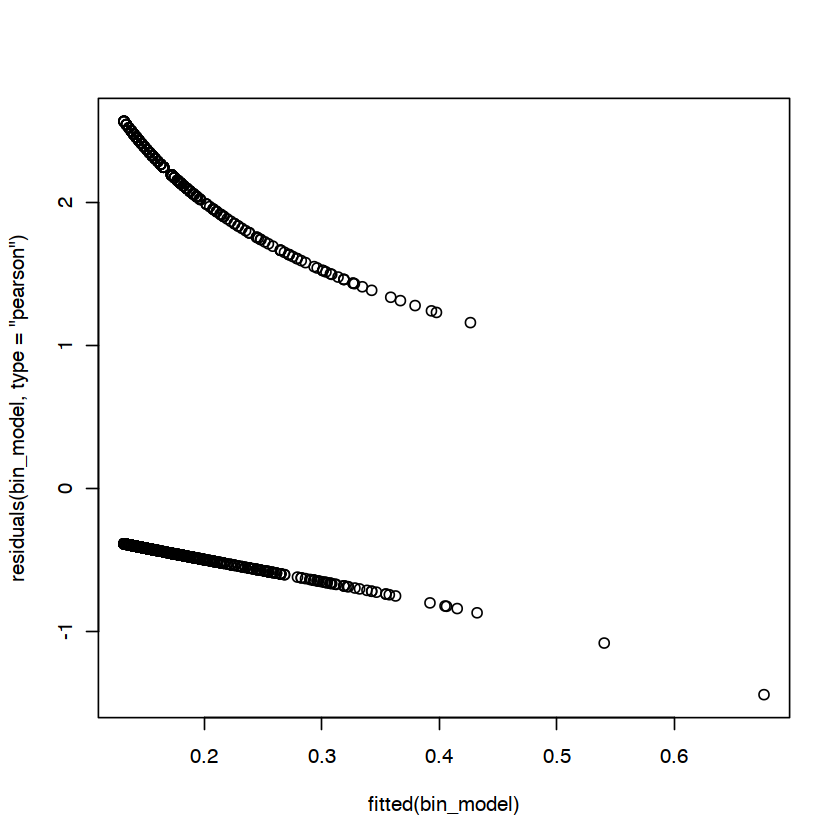

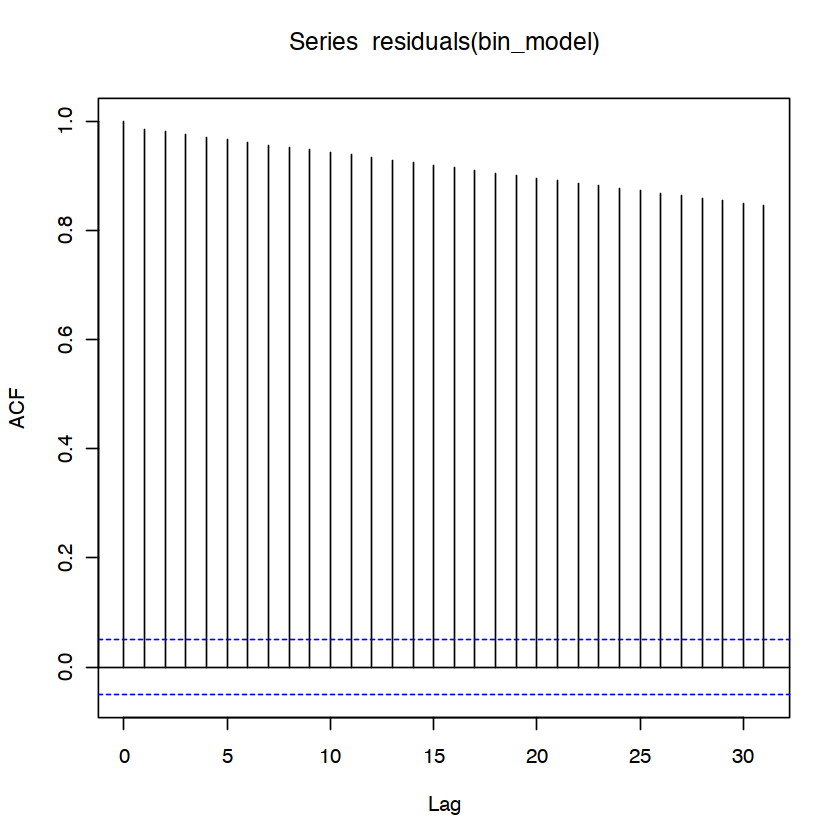

In [41]:
dat = dat
plot_assumptions = function(admission_type) {
    dat$AdmissionBin = as.numeric(dat$admission == admission_type)
    bin_model = glm(AdmissionBin ~ as.factor(died) + as.factor(white) + los, data=dat,family="binomial")
    plot(fitted(bin_model), residuals(bin_model, type="pearson"))

    acf(residuals(bin_model))
}

plot_assumptions("Urgent")

### Linear model between log odds and covariates

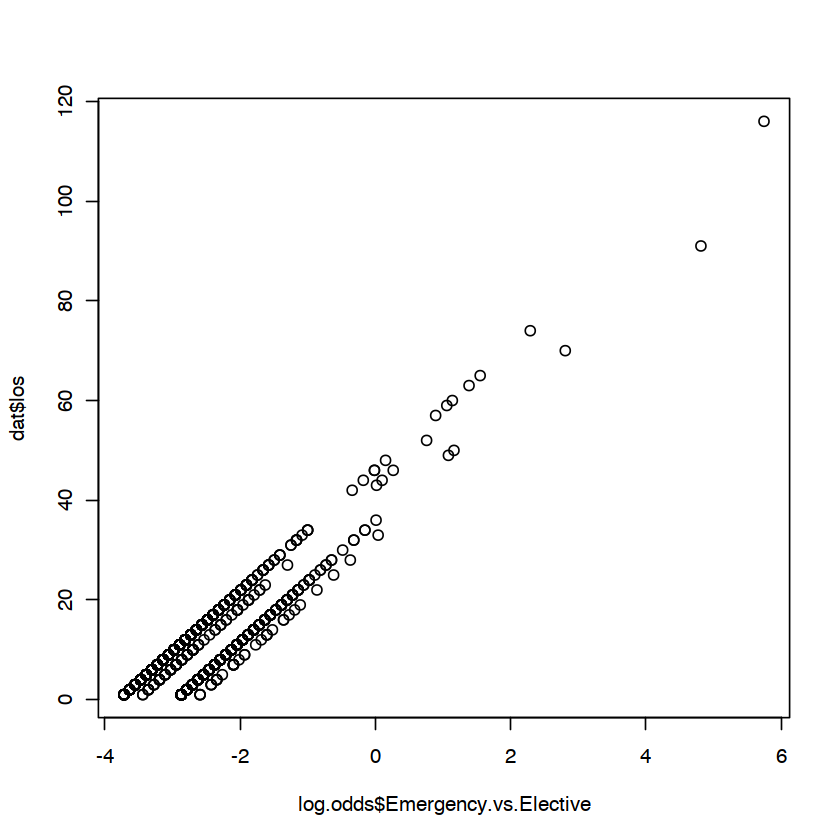

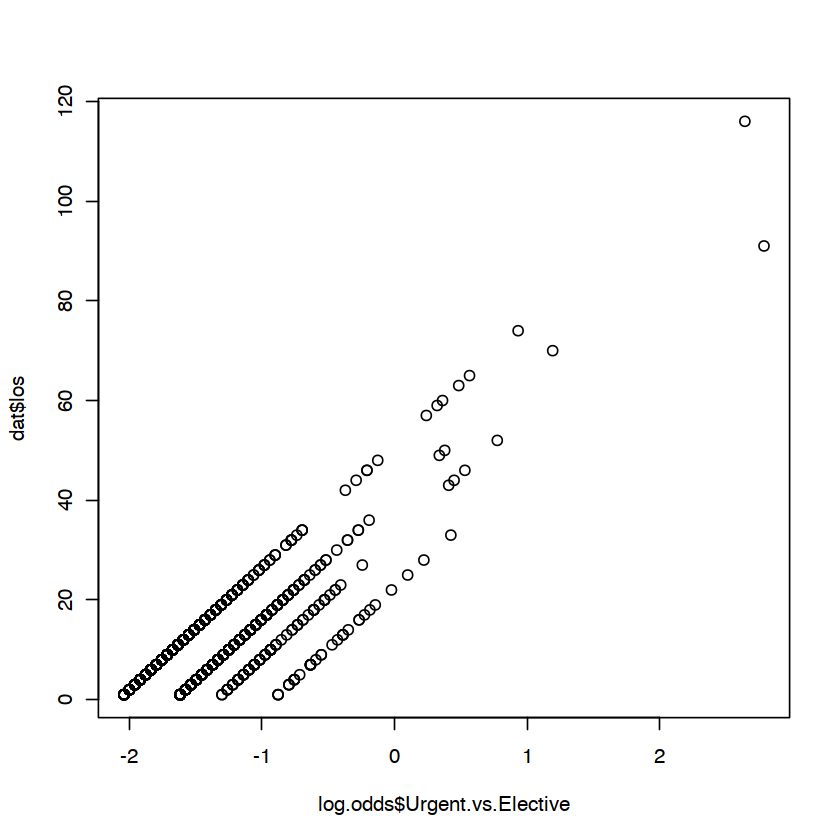

In [63]:
fitted_values = fitted(model)
log.odds = data.frame(
    Emergency.vs.Elective = log(fitted_values[,2]/fitted_values[,1]),
    Urgent.vs.Elective = log(fitted_values[,3]/fitted_values[,1])

)

plot(log.odds$Emergency.vs.Elective, dat$los)
plot(log.odds$Urgent.vs.Elective, dat$los)

In [67]:
llnull <- deviance(update(model, . ~ 1, trace=F))
llmod <- deviance(model)
RMcFadden <- 1 - (llmod/llnull)
RMcFadden

[1] 0.05144313

In [25]:
nrow(dat)

[1] 1495